In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import json


import matplotlib.colorbar as mplcb
import matplotlib.cm as mplcm

#sc.logging.print_header()
#sc.settings.verbosity = 3

In [4]:
def read_visium(path, library_id='stx'):
    r"""Read 10x-Genomics-formatted visum dataset.
    """
    path = Path(path)
    matrix_path = path / "filtered_feature_bc_matrix/"
    adata = sc.read_10x_mtx(matrix_path)

    adata.uns["spatial"] = dict()
    adata.uns["spatial"][library_id] = dict()

    tissue_positions_file = (
        path / "spatial/tissue_positions.csv"
        if (path / "spatial/tissue_positions.csv").exists()
        else path / "spatial/tissue_positions_list.csv"
    )
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=path / "spatial/scalefactors_json.json",
        hires_image=path / "spatial/tissue_hires_image.png",
        lowres_image=path / "spatial/tissue_lowres_image.png",
    )

    # check if files exists, continue if images are missing
    for f in files.values():
        if not f.exists():
            if any(x in str(f) for x in ["tissue_hires_image", "tissue_lowres_image"]):
                logg.warning(
                    f"You seem to be missing an image file.\nCould not find {f}."
                )
            else:
                msg = f"Could not find {f}"
                raise OSError(msg)

    adata.uns["spatial"][library_id]["images"] = dict()

    for res in ["hires", "lowres"]:
        image_path = str(files[f"{res}_image"])
        adata.uns["spatial"][library_id]["images"][res] = imread(image_path)
      
        # read json scalefactors
        adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
            files["scalefactors_json_file"].read_bytes()
        )

        # read coordinates
        positions = pd.read_csv(
            files["tissue_positions_file"],
            header=0 if tissue_positions_file.name == "tissue_positions.csv" else None,
            index_col=0,
        )
        positions.columns = [
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]

        adata.obs = pd.merge(
            adata.obs,
            positions,
            how='left',
            left_index=True,
            right_index=True,
        )

        adata.obsm["spatial"] = adata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
        adata.obs.drop(
            columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )

    return adata

fpath = "/HFD14/ST/"
current_directory = os.getcwd()+fpath
print(current_directory)
adata = read_visium(current_directory)
sc.logging.print_memory_usage()
adata

c:\Users\Ben\OneDrive\Documents\GitHub\STATS-547\ProblemSet5\Starter Code and Data/HFD14/ST/
Memory usage: current 0.27 GB, difference +0.27 GB


AnnData object with n_obs × n_vars = 1994 × 31053
    obs: 'in_tissue_x', 'array_row_x', 'array_col_x', 'in_tissue_y', 'array_row_y', 'array_col_y'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
# simple preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 1994 × 31053
    obs: 'in_tissue_x', 'array_row_x', 'array_col_x', 'in_tissue_y', 'array_row_y', 'array_col_y'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

C:\Users\Ben\AppData\Local\Temp\ipykernel_35880\3498164135.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


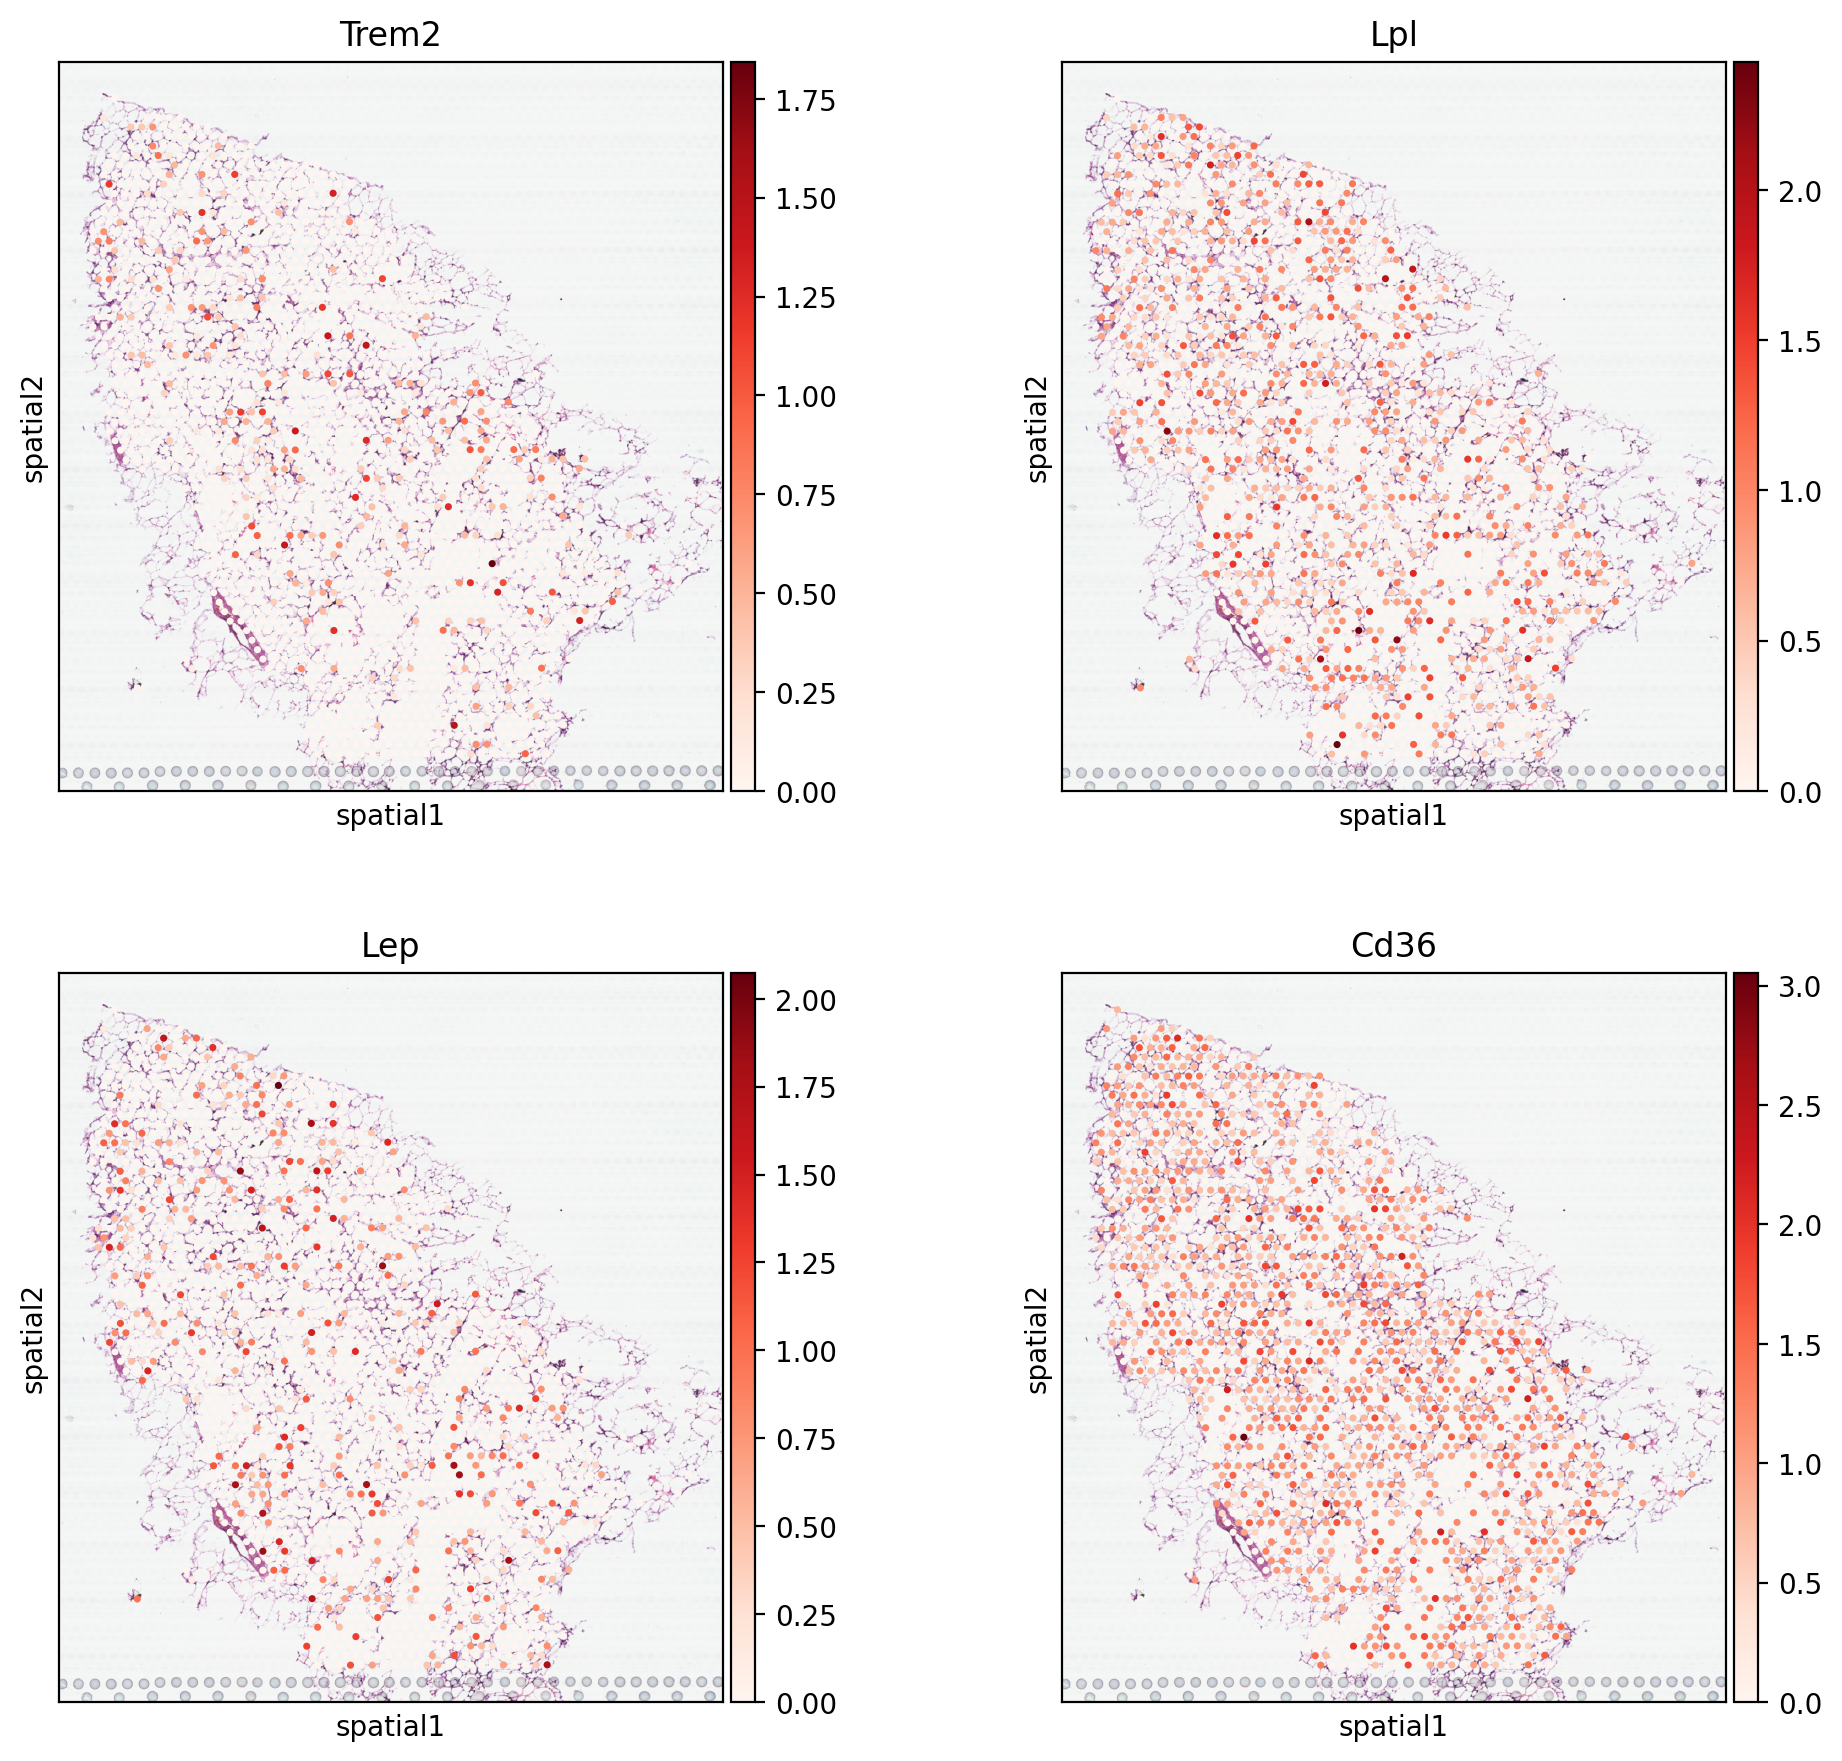

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5
sc.pl.spatial(
    adata, img_key="hires", 
    color=["Trem2", 'Lpl', 'Lep', 'Cd36'],
    color_map='Reds',
    ncols=2,
)

# Load the points for a single gene

In [7]:
gene = 'Trem2'

df = adata[:, gene].to_df()
print(f"{df.shape=}")

coords = pd.DataFrame(adata.obsm['spatial'], index=df.index, columns=['x', 'y'])
print(f"{coords.shape=}")

# merge in the coordinates
df = pd.merge(
    df, 
    coords, 
    how='left', 
    left_index=True, 
    right_index=True,
)

df.head()

df.shape=(1994, 1)
coords.shape=(1994, 2)


,Trem2,x,y
AAACATTTCCCGGATT-1,0.0,23202,27803
AAACCGGGTAGGTACC-1,0.0,9528,21281
AAACCGTTCGTCCAGG-1,0.0,12306,24722
AAACCTAAGCAGCCGG-1,0.0,20432,29186
AAACCTCATGAAGTTG-1,0.0,7743,19562


C:\Users\Ben\AppData\Local\Temp\ipykernel_35880\3173582000.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


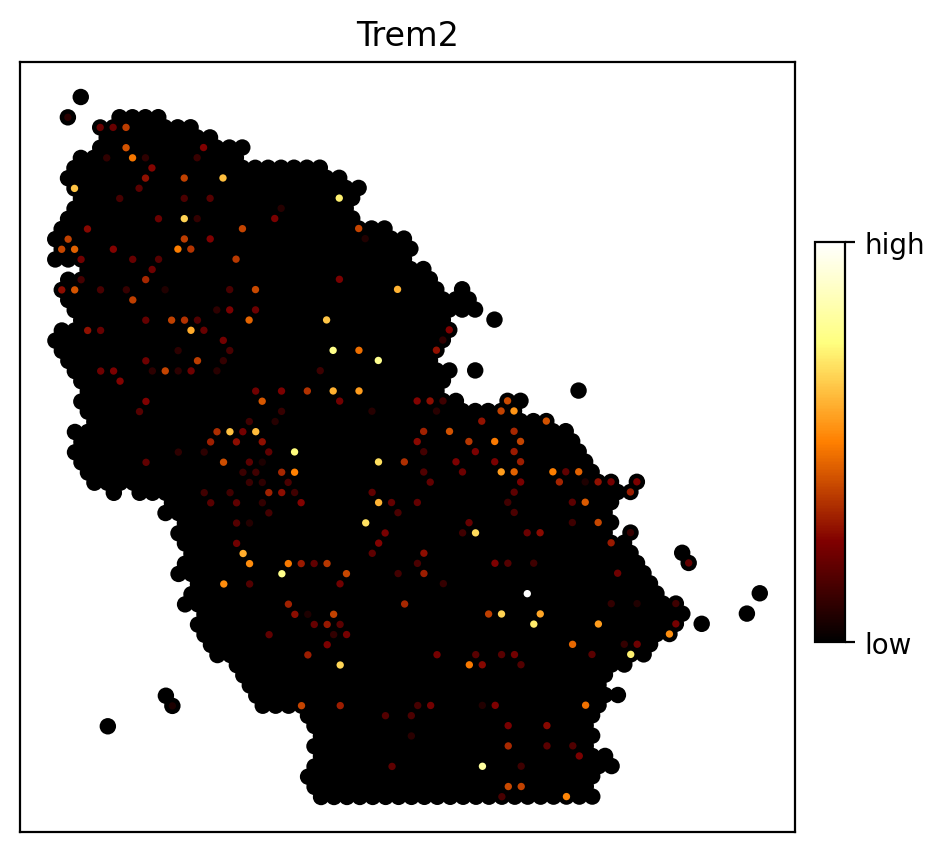

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

cmap = 'afmhot'

sns.scatterplot(
    data=df,
    x='x',
    y='y',
    c='k',
    palette='Reds',
    s=35,
    ec='none'
)

scatter_plot = sns.scatterplot(
    data=df,
    x='x',
    y='y',
    hue=gene,
    ec='none',
    palette=cmap,
    s=7,
    legend=False,
)

plt.gca().invert_yaxis()
plt.yticks([])
plt.xticks([])
plt.ylabel("")
plt.xlabel("")
plt.title(gene)

norm = plt.Normalize(df[gene].min(), df[gene].max())
sm = mplcm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) # need to set array for colorbar to work

cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.03, 0.4])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')

cbar.set_ticks([df[gene].min(), df[gene].max()])
cbar.set_ticklabels(['low', 'high'])

plt.show()